In [13]:
# Core data processing
import numpy as np
import pandas as pd
import geopandas as gpd

# Scientific computing and statistics
from kneed import KneeLocator
from scipy import stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cut_tree, dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from linearmodels.panel import PanelOLS
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'linearmodels'

In [173]:

def ng_factors(Y, rmax=10):
    import numpy as np

    p, n = Y.shape
    Y = Y - np.mean(Y, axis=0, keepdims=True)  # Column-wise centering

    c = np.linspace(0.05, 5, 100)
    re = 20
    IC = np.zeros((2, re, rmax, 100))
    gT1HL = np.ones(re)
    gT2HL = np.ones(re)
    pi = np.zeros(re, dtype=int)
    ni = np.zeros(re, dtype=int)

    for i in range(re):
        pi[i] = min(i * (p // re) + min(p, 5), p)
        ni[i] = min(i * (n // re) + min(n, 5), n)
        if i == re - 1:
            pi[i] = p
            ni[i] = n

        Yi = Y[:pi[i], :ni[i]]
        frob = np.zeros(rmax)

        for k in range(min(pi[i], ni[i], rmax)):
            eigenvals, V = np.linalg.eigh(Yi.T @ Yi)
            idx = eigenvals.argsort()[::-1]
            V = V[:, idx]
            F = V[:, : k + 1]
            LamPCA = Yi @ F / ni[i]
            uhat = Yi - LamPCA @ F.T
            frob[k] = np.trace(uhat @ uhat.T) / (pi[i] * ni[i])

            gT1HL[i] = (
                np.log((pi[i] * ni[i]) / (pi[i] + ni[i]))
                * (pi[i] + ni[i])
                / (pi[i] * ni[i])
            )
            gT2HL[i] = (
                np.log(min(pi[i], ni[i]))
                * (pi[i] + ni[i])
                / (pi[i] * ni[i])
            )

            for l in range(100):
                IC[0, i, k, l] = np.log(frob[k]) + c[l] * (k + 1) * gT1HL[i]
                IC[1, i, k, l] = np.log(frob[k]) + c[l] * (k + 1) * gT2HL[i]

    rhat = np.zeros((2, re, 100))
    for i in range(re):
        for l in range(100):
            m = min(pi[i], ni[i], rmax)
            rhat[0, i, l] = np.argmin(IC[0, i, :m, l]) + 1
            rhat[1, i, l] = np.argmin(IC[1, i, :m, l]) + 1

    Sc1 = np.std(rhat[0], axis=0)
    Sc2 = np.std(rhat[1], axis=0)

    c1vec = np.where(Sc1 == 0)[0]
    ctemp1 = c1vec[0]
    c1 = c[ctemp1]
    K1HL = int(rhat[0, 0, ctemp1])

    c2vec = np.where(Sc2 == 0)[0]
    ctemp2 = c2vec[0]
    c2 = c[ctemp2]
    K2HL = int(rhat[1, 0, ctemp2])

    IC = np.zeros((2, rmax))
    frob = np.zeros(rmax)

    for k in range(rmax):
        eigenvals, V = np.linalg.eigh(Y.T @ Y)
        idx = eigenvals.argsort()[::-1]
        V = V[:, idx]
        F = V[:, : k + 1]
        LamPCA = Y @ F / n
        uhat = Y - LamPCA @ F.T
        frob[k] = np.trace(uhat @ uhat.T) / (p * n)

        gT1BN = np.log((p * n) / (p + n)) * (p + n) / (p * n)
        gT2BN = np.log(min(p, n)) * (p + n) / (p * n)
        IC[0, k] = np.log(frob[k]) + (k + 1) * gT1BN
        IC[1, k] = np.log(frob[k]) + (k + 1) * gT2BN

    K1BN = np.argmin(IC[0]) + 1
    K2BN = np.argmin(IC[1]) + 1

    return {"K1HL": K1HL, "K2HL": K2HL, "K1BN": K1BN, "K2BN": K2BN, "IC": IC}


def st_facm(data, coords, typeD="COR", Wmat=None, maxitr=100, G=None, tol=0.0001):
    N = data.shape[1]

    # Step 1: Estimate K global factors
    K = ng_factors(data)["K1BN"] 

    # Step 2: Retrieve global factors (GF)
    cov_matrix = np.cov(data, rowvar=False)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
    P = eig_vectors[:, -K:] * np.sqrt(N)
    GF = (data @ P) / N

    # Step 3: Residuals (ResTS)
    E = data - GF @ P.T

    # Step 4: Spatio-temporal clustering of the residual

    # 4.1: TS Distance (D0)
    if typeD == "COR":
        # Calculate pairwise correlations
        cor_matrix = np.corrcoef(E.T)

        # Compute dissimilarity using the formula d1 = sqrt(2 * (1 - rho))
        D0_full = np.sqrt(2 * (1 - cor_matrix))

        # Normalize by the maximum value
        D0_full = D0_full / np.max(D0_full)

        # Initialize D0 as a zeros matrix
        D0 = np.zeros((N, N))

        # Extract only the lower triangular part (excluding diagonal)
        tril_indices = np.tril_indices(N, k=-1)
        D0[tril_indices] = D0_full[tril_indices]

        # Make the matrix symmetrical
        D0 = D0 + D0.T  # Add the transpose to mirror values above diagonal
    else:
        raise ValueError("Unsupported distance type")

    # 4.2: Spatial Distance (D1)
    if Wmat is None:
        D1 = squareform(pdist(coords))
        D1 = D1 / np.max(D1)
    else:
        Adj = Wmat.copy()
        np.fill_diagonal(Adj, 1)
        D1 = 1 - Adj

    res_hc = geo_clustf(D0, D1)
    hc = res_hc["clust"]

    # Sort heights in decreasing order (matching R's sort(res.hc$clust$height,decreasing = T))
    heights = np.sort(hc[:, 2])[::-1]  
    # Create matching x-values array (1 to N-1)
    x_values = np.arange(1, len(heights) + 1)

    # Plot screeplot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, heights, 'b-', marker='o')
    plt.title("Screeplot - spatio-temporal clustering")
    plt.ylabel("Height")
    plt.xlabel("Clusters")
    plt.show()

    # Determine optimal number of clusters
    if G is None:
        # Create x_values array of same length as heights
        x_range = np.arange(1, len(heights) + 1)
        nclust = elbow_finder(x_range, heights)[0]  # Use first element to get cluster number
    else:
        nclust = G


    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(hc)
    plt.title("Dendrogram")
    plt.show()

    clustering = fcluster(hc, t=nclust, criterion="maxclust")


    # Step 4: Estimating c-th local factors (c-LF)
    cLF = []
    Pc = []
    resC = []

    for c in range(1, nclust + 1):
        indices = np.where(clustering == c)[0]
        if len(indices) > K:
            dataclust = E[:, indices]
            rmax = min(len(indices), K)
            cov_dataclust = np.cov(dataclust, rowvar=False)
            eig_values, eig_vectors = np.linalg.eigh(cov_dataclust)
            Pc_c = eig_vectors[:, -rmax:] * np.sqrt(len(indices))
            cLF_c = (dataclust @ Pc_c) / len(indices)
            cLF.append(cLF_c)
            Pc.append(Pc_c)
            resC.append(dataclust - cLF_c @ Pc_c.T)
        else:
            cLF.append(0)
            Pc.append(0)
            resC.append(E[:, indices])


    #valvec = [np.sum(np.square(E)) / (N * data.shape[0])]

    # Initialize valvec and calculate initial value
    valvec = np.zeros(maxitr)
    val = np.sum([np.square(res).sum() for res in resC]) / (N * data.shape[0])
    valvec[0] = val

    # Main iteration loop
    for z in range(maxitr):
        cval = val
        
        # Calculate R matrix
        R = np.zeros_like(data)
        for c in range(nclust):
            cluster_mask = clustering == (c + 1)
            if isinstance(cLF[c], int):  # When cLF[c] == 0
                R[:, cluster_mask] = data[:, cluster_mask]
            else:
                R[:, cluster_mask] = data[:, cluster_mask] - cLF[c] @ Pc[c].T
    # Update global factors
        K = ng_factors(R)["K1BN"]
        cov_matrix = np.cov(R, rowvar=False)
        eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
        P = eig_vectors[:, -K:] * np.sqrt(N)
        GF = (R @ P) / N

        # Update residuals (E-tilde)
        for c in range(nclust):
            cluster_mask = clustering == (c + 1)
            if isinstance(cLF[c], int):  # When cLF[c] == 0
                E[:, cluster_mask] = R[:, cluster_mask] - GF @ P.T[:, cluster_mask]
            else:
                E[:, cluster_mask] = (R[:, cluster_mask] - GF @ P.T[:, cluster_mask] + 
                                    cLF[c] @ Pc[c].T)

        # Update clustering
        if typeD == "COR":
            cor_matrix = np.corrcoef(E.T)
            D0_full = np.sqrt(2 * (1 - cor_matrix))
            D0_full = D0_full / np.max(D0_full)
            D0 = np.zeros((N, N))
            tril_indices = np.tril_indices(N, k=-1)
            D0[tril_indices] = D0_full[tril_indices]
            D0 = D0 + D0.T

        res_hc = geo_clustf(D0, D1)
        hc = res_hc["clust"]
        
        if G is None:
            heights = np.sort(hc[:, 2])[::-1]
            nclust = elbow_finder(np.arange(1, len(heights) + 1), heights)[0]
        
        clustering = fcluster(hc, t=nclust, criterion="maxclust")

        # Update local factors
        cLF = []
        Pc = []
        resC = []

        for c in range(1, nclust + 1):
            indices = np.where(clustering == c)[0]
            if len(indices) > K:
                dataclust = E[:, indices]
                rmax = min(len(indices), K)
                cov_dataclust = np.cov(dataclust, rowvar=False)
                eig_values, eig_vectors = np.linalg.eigh(cov_dataclust)
                Pc_c = eig_vectors[:, -rmax:] * np.sqrt(len(indices))
                cLF_c = (dataclust @ Pc_c) / len(indices)
                cLF.append(cLF_c)
                Pc.append(Pc_c)
                resC.append(dataclust - cLF_c @ Pc_c.T)
            else:
                cLF.append(0)
                Pc.append(0)
                resC.append(E[:, indices])
        
    # Update convergence values
        val = np.sum([np.square(res).sum() for res in resC]) / (N * data.shape[0])
        #valvec[z + 1] = val
        
        # Check convergence
        dd = (cval - val) / val
        if abs(dd) < tol:
            break

    # Return final results
    return {
        "Global_Factors": GF,
        "Local_Factors": cLF,
        "Residuals": E,
        "nclust": nclust,
        "Global_Loadings": P,
        "Local_Loadings": Pc,
        "Weights": res_hc["Weights"],
        "clustering": clustering,
        "itr": z + 1,
        "obj": val
    }       



def elbow_finder(x_values, y_values):
    max_x_x = np.max(x_values)
    max_x_y = y_values[np.argmax(x_values)]
    max_y_y = np.max(y_values)
    max_y_x = x_values[np.argmax(y_values)]

    coeffs = np.polyfit([max_y_x, max_x_x], [max_y_y, max_x_y], 1)

    distances = np.abs(coeffs[0] * x_values - y_values + coeffs[1]) / np.sqrt(
        coeffs[0] ** 2 + 1
    )

    x_max_dist = x_values[np.argmax(distances)]
    y_max_dist = y_values[np.argmax(distances)]

    return x_max_dist, y_max_dist


def calc_combined_dist(D0, D1, alpha):
    return (1-alpha)*D0 + alpha*D1

def find_elbow(heights):
    kn = KneeLocator(range(1, len(heights)+1), heights, 
                     curve='convex', direction='decreasing')
    return kn.knee

def calc_q_norms(D0, D1, alpha_range, k):
    q_norms = []
    for alpha in alpha_range:
        D_alpha = calc_combined_dist(D0, D1, alpha)
        linkage = hierarchy.linkage(squareform(D_alpha), method='average')
        labels = hierarchy.fcluster(linkage, k, criterion='maxclust')
        
        q0 = np.sum([D0[i,j] for i in range(len(labels)) 
                    for j in range(i+1,len(labels)) 
                    if labels[i] == labels[j]])
        q1 = np.sum([D1[i,j] for i in range(len(labels)) 
                    for j in range(i+1,len(labels)) 
                    if labels[i] == labels[j]])
        q_norms.append([q0, q1])
    return np.array(q_norms)

def geo_clustf(D0, D1):
    # Initial clustering (alpha=0)
    d_init = calc_combined_dist(D0, D1, 0)
    res_hc_init = hierarchy.linkage(squareform(d_init), method='average')
    
    # Find optimal k using elbow method
    heights = sorted(res_hc_init[:,2], reverse=True)
    k = find_elbow(heights)
    
    # Find optimal alpha
    alphas = np.linspace(0, 1, 11)
    q_norms = calc_q_norms(D0, D1, alphas, k)
    a = alphas[np.argmin(np.abs(q_norms[:,0] - q_norms[:,1]))]
    
    # Final clustering with optimal alpha
    d_final = calc_combined_dist(D0, D1, a)
    res_hc_final = hierarchy.linkage(squareform(d_final), method='average')
    
    return {
        "clust": res_hc_final,
        "Weights": a,
        "dist_mat": d_final
    }

In [174]:
# A. Application to house prices
Data = pd.read_csv("PriceUS.csv", header = None)
Data.columns = ["State", "Year", "Quarter", "Index"]
Data = Data.sort_values(by=['State', 'Year']).reset_index(drop=True)
Data

,State,Year,Quarter,Index
0,AK,1975,1,62.02
1,AK,1975,2,63.93
2,AK,1975,3,68.23
3,AK,1975,4,68.02
4,AK,1976,1,71.36
...,...,...,...,...
9838,WY,2022,1,416.42
9839,WY,2022,2,440.49
9840,WY,2022,3,451.48
9841,WY,2022,4,450.89


In [175]:
Prices = Data.pivot(index=["Year", "Quarter"], columns="State", values="Index")
Prices = Prices.reset_index()
Prices = Prices.iloc[:, 2:]
Prices

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,62.02,75.02,66.54,60.63,41.70,54.16,62.28,47.84,77.03,65.93,...,75.04,68.03,55.63,55.15,69.84,77.35,46.26,61.86,50.24,49.17
1,63.93,72.22,60.19,59.87,42.75,54.85,62.82,47.60,89.58,83.43,...,70.33,68.72,58.60,58.77,66.78,76.88,47.18,62.79,65.34,47.84
2,68.23,74.62,64.92,59.44,44.31,54.81,61.86,47.32,115.70,66.80,...,65.02,67.75,56.16,55.17,67.51,67.11,49.72,64.60,66.18,50.11
3,68.02,71.70,62.80,56.33,45.76,55.00,61.88,54.68,71.70,68.20,...,63.86,70.89,59.34,59.89,67.74,72.88,48.05,69.04,66.74,53.54
4,71.36,77.10,66.82,58.96,47.80,55.01,64.80,53.09,79.56,67.95,...,62.88,70.29,58.65,62.25,69.37,117.03,50.36,65.48,61.51,54.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,395.65,434.23,378.27,644.06,868.66,775.39,522.84,1061.02,605.76,678.13,...,520.10,559.61,459.73,754.82,601.52,649.14,911.13,463.48,283.30,416.42
189,417.00,460.84,402.97,694.24,923.66,836.66,555.63,1108.93,642.69,735.32,...,555.57,603.61,493.63,813.03,642.30,695.77,975.15,499.11,297.27,440.49
190,422.39,475.29,416.26,704.49,917.97,828.09,566.25,1095.17,647.11,767.01,...,567.54,622.95,503.83,808.48,650.31,730.52,966.46,509.86,303.24,451.48
191,415.87,475.92,417.27,680.97,896.49,811.19,564.56,1075.14,650.27,766.60,...,570.90,623.18,500.08,783.06,650.74,719.62,938.28,506.40,302.43,450.89


In [176]:
PricePlot = Prices.drop(Prices.columns[[0, 11]], axis=1)
PricePlot = PricePlot.apply(lambda x: (x / x.iloc[0]) * 100, axis=0)
Dates = pd.date_range(start="1975-01-01", end="2023-01-01", freq='3MS')
PricePlot

State,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,96.267662,90.456868,98.746495,102.517986,101.274003,100.867052,99.498328,116.292354,126.543304,97.412976,...,93.723348,101.014258,105.338846,106.563917,95.618557,99.392372,101.988759,101.503395,130.055732,97.295099
2,99.466809,97.565374,98.037275,106.258993,101.200148,99.325626,98.913043,150.201220,101.319581,100.555330,...,86.647122,99.588417,100.952723,100.036265,96.663803,86.761474,107.479464,104.429357,131.727707,101.911735
3,95.574513,94.379321,92.907801,109.736211,101.550960,99.357739,114.297659,93.080618,103.443046,99.864554,...,85.101279,104.204028,106.669063,108.594742,96.993127,94.221073,103.869434,111.606854,132.842357,108.887533
4,102.772594,100.420800,97.245588,114.628297,101.569424,104.046243,110.974080,103.284435,103.063856,96.749289,...,83.795309,103.322064,105.428726,112.873980,99.327033,151.299289,108.862949,105.851924,122.432325,110.372178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,578.818982,568.485122,1062.279400,2083.117506,1431.665436,839.499037,2217.851171,786.394911,1028.560595,711.255587,...,693.097015,822.592974,826.406615,1368.667271,861.282932,839.224305,1969.584955,749.240220,563.893312,846.898515
189,614.289523,605.605651,1145.043708,2215.011990,1544.793205,892.148362,2317.997492,834.337271,1115.304110,763.673304,...,740.365139,887.270322,887.344958,1474.215775,919.673540,899.508727,2107.976654,806.838021,591.699841,895.851129
190,633.551053,625.578599,1161.949530,2201.366906,1528.969719,909.200385,2289.234950,840.075295,1163.370241,785.751050,...,756.316631,915.698956,905.680388,1465.965549,931.142612,944.434389,2089.191526,824.215972,603.582803,918.202156
191,634.390829,627.096483,1123.156853,2149.856115,1497.765879,906.486834,2247.366221,844.177593,1162.748369,787.877557,...,760.794243,916.037042,898.939421,1419.873073,931.758305,930.342599,2028.274968,818.622696,601.970541,917.002237


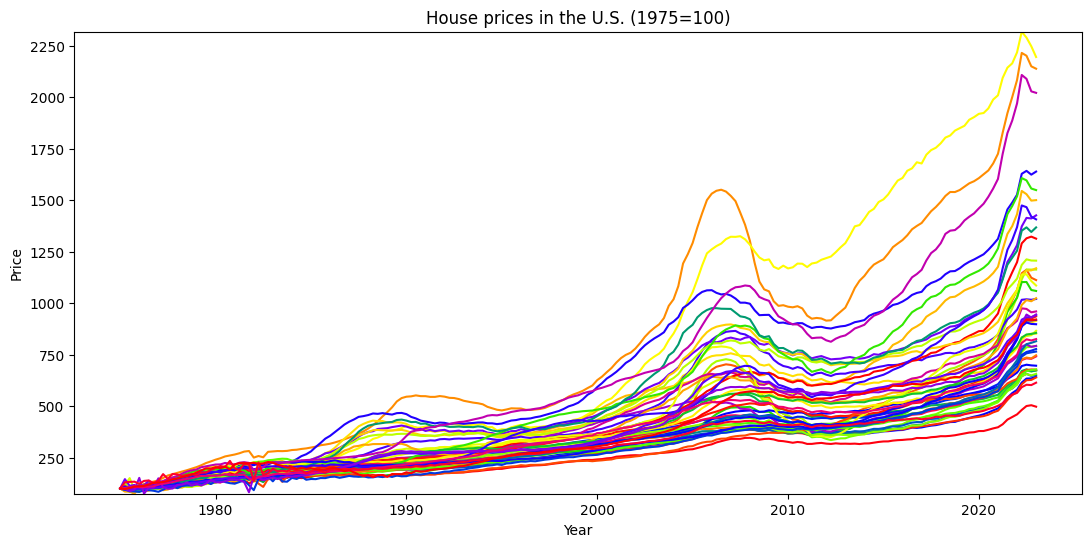

In [177]:
plt.figure(figsize=(13,6))
plt.plot(Dates, PricePlot.iloc[:, 0], label=Prices.columns[0], color='blue')
plt.ylim(min(PricePlot.values.flatten()), max(PricePlot.values.flatten()))
plt.ylabel("Price")
plt.xlabel("Year")
plt.title("House prices in the U.S. (1975=100)")

for i in range(1, PricePlot.shape[1]):
    plt.plot(Dates, PricePlot.iloc[:, i], label=Prices.columns[i], color=plt.cm.prism(50 + i))

#plt.legend()
plt.show()

In [178]:
LatLong = pd.read_excel("LatLongUS.xlsx")
LatLong.shape

(52, 4)

In [179]:
LatLong = LatLong.drop(index=39).reset_index(drop=True)
LatLong.shape

(51, 4)

In [180]:
#Wmat = usaww / usaww
#Wmat = np.nan_to_num(Wmat) # Replace NaN values with 0
dPrice = Prices.apply(lambda x: (x - x.shift(1)) / x.shift(1), axis=0)
dPrice = dPrice.iloc[1:, :]  # Drop the first row
dPrice = dPrice.drop(dPrice.columns[[0, 11]], axis=1)  # Drop 1st and 12th columns
dPrice.head()  # View the result

State,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
1,-0.037323,-0.095431,-0.012535,0.025180,0.012740,0.008671,-0.005017,0.162924,0.265433,-0.025870,...,-0.062767,0.010143,0.053388,0.065639,-0.043814,-0.006076,0.019888,0.015034,0.300557,-0.027049
2,0.033232,0.078584,-0.007182,0.036491,-0.000729,-0.015282,-0.005882,0.291583,-0.199329,0.032258,...,-0.075501,-0.014115,-0.041638,-0.061256,0.010931,-0.127081,0.053836,0.028826,0.012856,0.047450
3,-0.039132,-0.032656,-0.052322,0.032724,0.003467,0.000323,0.155537,-0.380294,0.020958,-0.006870,...,-0.017841,0.046347,0.056624,0.085554,0.003407,0.085978,-0.033588,0.068731,0.008462,0.068449
4,0.075314,0.064013,0.046689,0.044580,0.000182,0.047188,-0.029078,0.109623,-0.003666,-0.031195,...,-0.015346,-0.008464,-0.011628,0.039406,0.024063,0.605790,0.048075,-0.051564,-0.078364,0.013635
5,-0.037354,0.026938,0.064959,0.051674,0.087620,-0.009722,-0.001507,0.061463,0.118175,0.022400,...,0.075223,-0.024755,0.083717,-0.011245,-0.011388,-0.508588,0.064535,-0.000916,0.115428,0.019716


In [181]:
# map plot and clusters validation

def print_cluster_details(clusters, coords_indexed):
    for i, cluster in enumerate(clusters):
        print(f"\nCluster {i+1}:")
        print("-" * 50)
        print(f"{'State':<4} {'Latitude':>10} {'Longitude':>12} {'Name':<20}")
        print("-" * 50)
        for idx in cluster:
            row = coords_indexed[idx]
            print(f"{row[1]:<4} {row[2]:>10.3f} {row[3]:>12.3f} {row[4]:<20}")
        print(f"Number of states in cluster: {len(cluster)}\n")


def visualize_clusters(clusters, coords_indexed):
    import geopandas as gpd
    import matplotlib.pyplot as plt
    
    # Load and prepare the map
    us_states = gpd.read_file('map/ne_110m_admin_1_states_provinces.shp')
    us_states = us_states[~us_states['name'].isin(['Alaska', 'Hawaii'])]
    
    # Create cluster mapping dictionary
    cluster_map = {}
    for cluster_idx, cluster in enumerate(clusters):
        for state_idx in cluster:
            state_code = coords_indexed[state_idx][1]
            cluster_map[state_code] = len(clusters) - cluster_idx - 1
    
    # Assign clusters to states
    us_states['cluster'] = us_states['iso_3166_2'].str[3:].map(cluster_map)
    
    # Create plotted_clusters list
    plotted_clusters = []
    for i in range(len(clusters)):
        states_in_cluster = us_states[us_states['cluster'] == i]['iso_3166_2'].str[3:].tolist()
        plotted_clusters.append(sorted(states_in_cluster))
    
    # Visualization
    colors = ["red", "blue", "darkgreen", "gold", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"]
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    for i in range(len(clusters)):
        state_subset = us_states[us_states['cluster'] == i]
        if not state_subset.empty:
            state_subset.plot(
                ax=ax,
                color=colors[i],
                edgecolor='black',
                linewidth=0.5,
                label=f"Cluster {len(clusters) - i}"
            )
    
    ax.axis('off')
    ax.set_title('US States Clustering Analysis', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return plotted_clusters[::-1]

def print_cluster_comparison(input_clusters, coords_indexed, plotted_clusters):
    print("=== INPUT CLUSTERS ===")
    for i, cluster in enumerate(input_clusters):
        print(f"\nCluster {i+1}:")
        print("-" * 30)
        print(' '.join(sorted([coords_indexed[idx][1] for idx in cluster])))
    
    print("\n=== PLOTTED CLUSTERS ===")
    for i, cluster in enumerate(plotted_clusters):
        print(f"\nCluster {i+1}:")
        print("-" * 30)
        print(' '.join(sorted(cluster)))


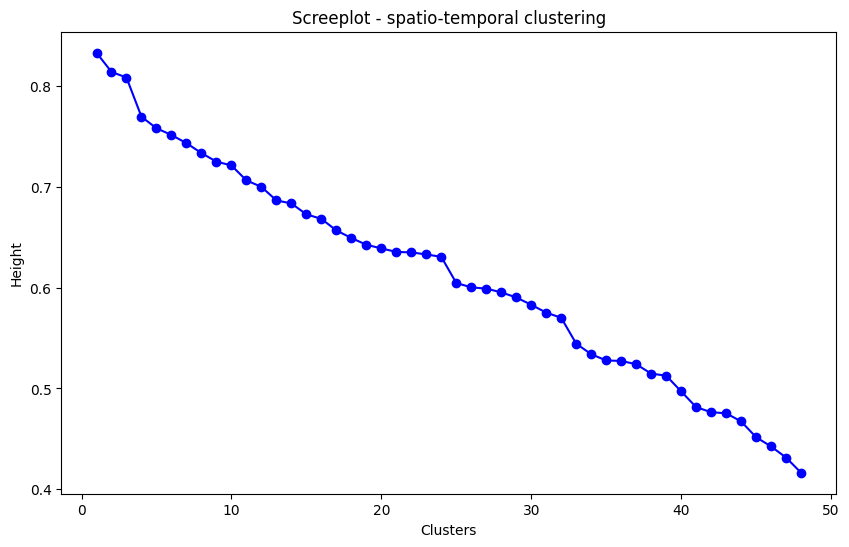

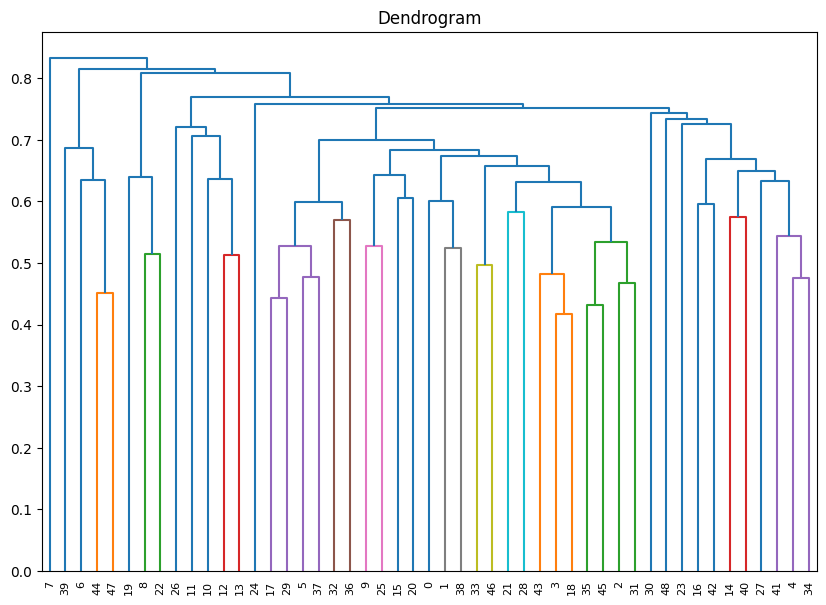

In [182]:
# coords = LatLong.drop(index=[0, 11]).iloc[:, [1, 2]].values
coords_with_info = LatLong.drop(index=[0, 11])[['state', 'latitude', 'longitude', 'name']].values
coords_indexed = np.array([(i, *row) for i, row in enumerate(coords_with_info)], dtype=object)

coords = coords_indexed[:, [2, 3]].astype(float)

# Convert dPrice to a NumPy array
data = dPrice.values

# Perform clustering using st_facm function
FullSample = st_facm(data, coords, typeD="COR")

# Extract the estimated factors
Global_Factors = FullSample["Global_Factors"]
Local_Factors = FullSample["Local_Factors"]

clusters = [list(np.where(FullSample["clustering"] == i)[0]) for i in range(1, FullSample["nclust"] + 1)]

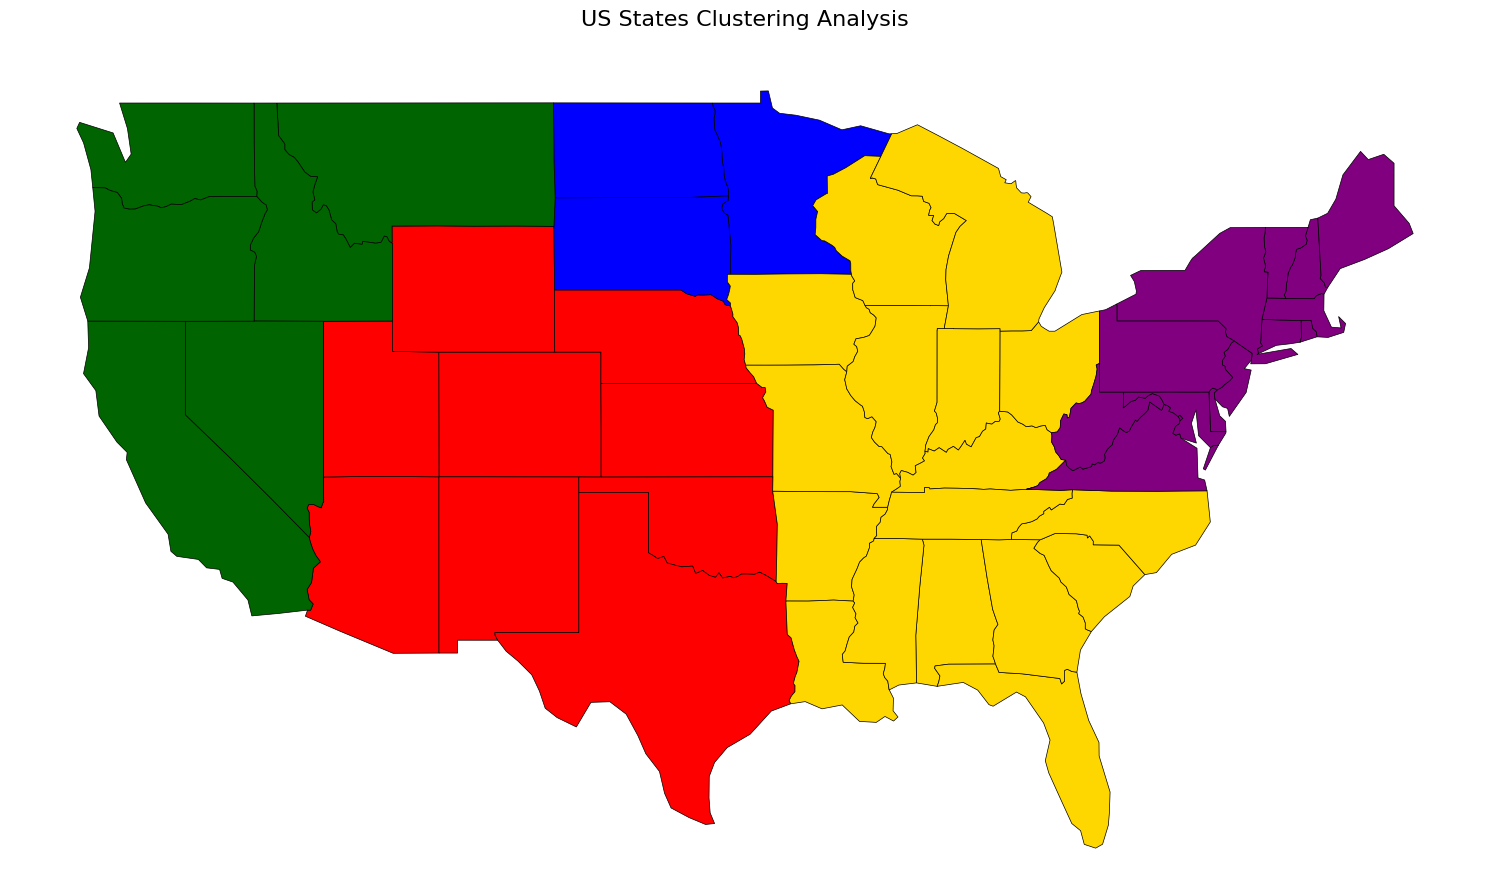

=== INPUT CLUSTERS ===

Cluster 1:
------------------------------
CT DC DE MA MD ME NH NJ NY PA RI VA VT WV

Cluster 2:
------------------------------
AL AR FL GA IA IL IN KY LA MI MO MS NC OH SC TN WI

Cluster 3:
------------------------------
CA ID MT NV OR WA

Cluster 4:
------------------------------
MN ND SD

Cluster 5:
------------------------------
AZ CO KS NE NM OK TX UT WY

=== PLOTTED CLUSTERS ===

Cluster 1:
------------------------------
CT DC DE MA MD ME NH NJ NY PA RI VA VT WV

Cluster 2:
------------------------------
AL AR FL GA IA IL IN KY LA MI MO MS NC OH SC TN WI

Cluster 3:
------------------------------
CA ID MT NV OR WA

Cluster 4:
------------------------------
MN ND SD

Cluster 5:
------------------------------
AZ CO KS NE NM OK TX UT WY


In [183]:
plotted_states = visualize_clusters(clusters, coords_indexed)
print_cluster_comparison(clusters, coords_indexed, plotted_states)

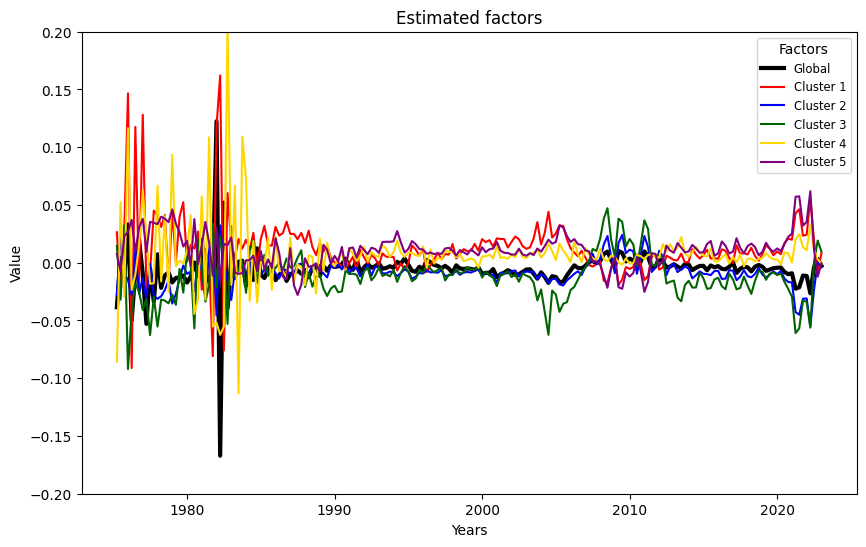

In [184]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Dates[1:], Global_Factors, label="Global", color="black", linewidth=3)

# Add lines for each local factor
colors = ["red", "blue", "darkgreen", "gold", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"]
for i, factor in enumerate(Local_Factors):
    plt.plot(Dates[1:], factor, label=f"Cluster {i + 1}", color=colors[i])

# Add plot labels, title, and legend
plt.xlabel("Years")
plt.ylabel("Value")
plt.title("Estimated factors")
plt.ylim(-0.2, 0.2)
plt.legend(loc="upper right", fontsize="small", title="Factors")
plt.show()

In [185]:
# application to CPI data
CPI = pd.read_csv("CPI_growth.csv")
#CPI = CPI.values
CPI

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0.029979,0.029979,0.030435,0.030435,0.030435,0.021912,0.029979,0.029979,0.029979,0.029979,...,0.027542,0.029979,0.029979,0.030435,0.029979,0.021912,0.030435,0.027542,0.029979,0.030435
1,0.041580,0.041580,0.031646,0.031646,0.031646,0.031189,0.041580,0.041580,0.041580,0.041580,...,0.026804,0.041580,0.041580,0.031646,0.041580,0.031189,0.031646,0.026804,0.041580,0.031646
2,0.023952,0.023952,0.030675,0.030675,0.030675,0.022684,0.023952,0.023952,0.023952,0.023952,...,0.026104,0.023952,0.023952,0.030675,0.023952,0.022684,0.030675,0.026104,0.023952,0.030675
3,0.017544,0.017544,0.021825,0.021825,0.021825,0.011091,0.017544,0.017544,0.017544,0.017544,...,0.015656,0.017544,0.017544,0.021825,0.017544,0.011091,0.021825,0.015656,0.017544,0.021825
4,0.019157,0.019157,0.019417,0.019417,0.019417,0.014625,0.019157,0.019157,0.019157,0.019157,...,0.019268,0.019157,0.019157,0.019417,0.019157,0.014625,0.019417,0.019268,0.019157,0.019417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.012351,0.012351,0.007492,0.007492,0.007492,0.010906,0.012351,0.012351,0.012351,0.012351,...,0.012099,0.012351,0.012351,0.007492,0.012351,0.010906,0.007492,0.012099,0.012351,0.007492
188,0.022932,0.022932,0.025100,0.025100,0.025100,0.020161,0.022932,0.022932,0.022932,0.022932,...,0.025254,0.022932,0.022932,0.025100,0.022932,0.020161,0.025100,0.025254,0.022932,0.025100
189,0.016854,0.016854,0.016029,0.016029,0.016029,0.012328,0.016854,0.016854,0.016854,0.016854,...,0.018262,0.016854,0.016854,0.016029,0.016854,0.012328,0.016029,0.018262,0.016854,0.016029
190,0.016995,0.016995,0.015122,0.015122,0.015122,0.013068,0.016995,0.016995,0.016995,0.016995,...,0.014096,0.016995,0.016995,0.015122,0.016995,0.013068,0.015122,0.014096,0.016995,0.015122


In [186]:
RealInc = pd.read_csv("RealInc_growth.csv")
RealInc

,AL,AZ,AR,CA,CO,CT,DE,DC,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
0,0.021893,0.005028,0.010371,0.021727,0.019088,0.011821,0.012016,0.001816,0.022519,0.003535,...,0.085257,0.008102,0.039273,0.024444,0.012738,0.021654,0.019830,0.065229,0.015586,0.022263
1,0.027065,0.022654,0.024532,0.026799,0.033327,0.014647,-0.000483,0.025365,0.026633,0.031275,...,0.025811,0.026725,0.030634,0.023402,0.027050,0.020936,0.036924,0.013872,0.022967,0.029614
2,0.038437,0.034161,0.050264,0.025957,0.032258,0.017338,0.032305,0.020639,0.019376,0.022125,...,0.037154,0.031360,0.033199,0.037348,0.029399,0.025059,0.027658,0.016367,0.033349,0.033757
3,0.031068,0.025028,0.014603,0.026846,0.021254,0.020683,0.033462,0.017481,0.017084,0.038858,...,0.013042,0.032768,0.034127,0.025757,0.035728,0.021724,0.027977,0.041113,0.026261,0.030428
4,0.038258,0.026255,0.037618,0.026044,0.025265,0.015075,0.013352,0.001904,0.027989,0.027457,...,-0.017863,0.037044,0.034484,0.034314,0.021463,0.036947,0.024952,0.043009,0.018385,0.021872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.014924,0.017710,0.005939,-0.003282,0.019249,0.008268,0.014223,-0.007593,0.016975,0.012160,...,-0.003465,0.015971,0.020137,0.026073,0.004362,0.012810,0.011279,0.012980,0.009168,0.018061
188,0.004804,0.018937,0.009448,-0.006195,0.017033,0.015531,0.064783,-0.023093,0.009926,-0.000347,...,0.042390,0.018905,0.013385,0.012017,0.021168,0.009486,0.001902,0.012056,0.009635,0.016579
189,0.013238,0.017834,0.008911,0.003660,0.011976,0.001544,0.025650,0.012442,0.020656,0.021307,...,0.019434,0.009881,0.019483,0.019741,0.015494,0.013360,0.009697,0.010377,0.007596,0.008965
190,0.020059,0.019150,0.029930,0.013108,0.038015,0.019475,0.021746,0.017916,0.023286,0.011597,...,0.014253,0.015093,0.022189,0.022238,0.010684,0.023356,0.016265,0.008362,0.018844,0.017436


In [187]:
ltIR = pd.read_csv("LongTerm_ir.csv")
ltIR

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,...,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949,-0.016949
1,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,...,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639,0.067639
2,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,...,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642,0.030642
3,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,...,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124,-0.028124
4,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,...,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446,-0.038446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,...,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209,0.161209
188,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,...,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473,0.262473
189,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,...,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309,0.510309
190,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,...,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296,0.060296


In [188]:
RealInc = RealInc[sorted(RealInc.columns)]
CPI = CPI[sorted(CPI.columns)]
ltIR = ltIR[sorted(ltIR.columns)]
print(RealInc.columns, CPI.columns, ltIR.columns)
#RealInc.columns, CPI.columns, ltIR.columns
RealInc = RealInc.values
CPI = CPI.values
ltIR = ltIR.values

Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object') Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object') Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT'

In [189]:
#Create id and timeid arrays
id = np.tile(np.array(dPrice.columns), (dPrice.shape[0], 1))
timeid = np.tile(np.arange(1, dPrice.shape[0] + 1), (dPrice.shape[1], 1)).T

# Extract F0 and Fg
F0 = FullSample["Global_Factors"]
Fg = dPrice.copy()
#for i, cluster in enumerate(FullSample["clustering"]):
#    Fg.iloc[:, cluster == i + 1] = FullSample["Local_Factors"][i]

#do it without for loop
Fg = dPrice.copy()
Fg.iloc[:, FullSample["clustering"] == 1] = FullSample["Local_Factors"][0]
Fg.iloc[:, FullSample["clustering"] == 2] = FullSample["Local_Factors"][1]
Fg.iloc[:, FullSample["clustering"] == 3] = FullSample["Local_Factors"][2]
Fg.iloc[:, FullSample["clustering"] == 4] = FullSample["Local_Factors"][3]
Fg.iloc[:, FullSample["clustering"] == 5] = FullSample["Local_Factors"][4]



panel_data = {
    "id": id.ravel(),
    "time": timeid.ravel(),
    "price": dPrice.values.ravel(),
    "cpi": CPI.ravel(),
    "ri": RealInc.ravel(),
    "itr": ltIR.ravel(),
    "F0": np.repeat(F0, dPrice.shape[1]),
    "Fg": Fg.values.ravel()
}

df0 = pd.DataFrame(panel_data)

df0

,id,time,price,cpi,ri,itr,F0,Fg
0,AL,1,-0.037323,0.029979,0.021893,-0.016949,-0.038557,-0.027957
1,AR,1,-0.095431,0.029979,0.010371,-0.016949,-0.038557,-0.027957
2,AZ,1,-0.012535,0.030435,0.005028,-0.016949,-0.038557,0.007665
3,CA,1,0.025180,0.030435,0.021727,-0.016949,-0.038557,0.014639
4,CO,1,0.012740,0.030435,0.019088,-0.016949,-0.038557,0.007665
...,...,...,...,...,...,...,...,...
9403,VT,192,0.015800,0.019777,0.020505,0.232833,-0.002661,0.008101
9404,WA,192,-0.003506,0.023132,0.012849,0.232833,-0.002661,0.009614
9405,WI,192,0.008195,0.021440,0.002776,0.232833,-0.002661,-0.004001
9406,WV,192,0.019310,0.025022,0.011119,0.232833,-0.002661,0.008101


In [190]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR, ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Load the dataframe (replace with your data loading method)
# Example: df0 = pd.read_csv('your_file.csv')

data_columns = ['price', 'cpi', 'ri', 'itr', 'F0', 'Fg']
id_column = 'id'
time_column = 'time'

def panel_var_forecast(df, data_columns, id_column, time_column, forecast_steps=1):
    # Prepare the data for VAR or ARIMA
    results = []
    groups = df.groupby(id_column)

    for name, group in groups:
        group = group.sort_values(by=time_column)
        model_data = group[data_columns]

        if len(data_columns) > 1:
            # Fit VAR model
            model = VAR(model_data)
            fitted_model = model.fit()

            # Forecast
            lag_order = fitted_model.k_ar
            forecast_input = model_data.values[-lag_order:]
            forecast = fitted_model.forecast(y=forecast_input, steps=forecast_steps)
        else:
            # Fit ARIMA model for single variable
            model = ARIMA(model_data['price'], order=(1, 1, 1))
            fitted_model = model.fit()

            # Forecast
            forecast = fitted_model.forecast(steps=forecast_steps).values.reshape(-1, 1)

        # Collect results
        forecast_df = pd.DataFrame(forecast, columns=data_columns)
        forecast_df[time_column] = group[time_column].max() + np.arange(1, forecast_steps + 1)
        forecast_df[id_column] = name
        results.append(forecast_df)

    # Combine all results
    forecast_results = pd.concat(results, ignore_index=True)

    # Calculate RMSE and MAE for each group
    errors = []
    for name, group in groups:
        group = group.sort_values(by=time_column)
        model_data = group[data_columns]

        if len(data_columns) > 1:
            # Fit VAR model
            model = VAR(model_data)
            fitted_model = model.fit()

            # Predict on training data
            lag_order = fitted_model.k_ar
            predictions = fitted_model.fittedvalues.to_numpy()
            true_values = model_data.iloc[lag_order:].to_numpy()
        else:
            # Fit ARIMA model for single variable
            model = ARIMA(model_data['price'], order=(1, 1, 1))
            fitted_model = model.fit()

            # Predict on training data
            predictions = fitted_model.fittedvalues.iloc[1:].to_numpy().reshape(-1, 1)
            true_values = model_data['price'].iloc[1:].to_numpy().reshape(-1, 1)

        # Calculate errors
        rmse = sqrt(mean_squared_error(true_values[:, 0], predictions[:, 0]))
        mae = mean_absolute_error(true_values[:, 0], predictions[:, 0])
        errors.append({id_column: name, 'RMSE': rmse, 'MAE': mae})

    errors_df = pd.DataFrame(errors)

    return forecast_results, errors_df

# Example usage
all_forecast_results = []
all_errors = []

for i in range(len(data_columns), 0, -1):
    subset_columns = data_columns[:i]
    forecast_results, errors_df = panel_var_forecast(df0, subset_columns, id_column, time_column, forecast_steps=1)
    all_forecast_results.append((subset_columns, forecast_results))
    all_errors.append((subset_columns, errors_df))

# Output results for each model
for subset_columns, forecast_results in all_forecast_results:
    print(f"Forecast Results for columns: {subset_columns}")
    print(forecast_results.head())

for subset_columns, errors_df in all_errors:
    print(f"Error Metrics for columns: {subset_columns}")
    print(errors_df.head())



c:\Users\dabro\Desktop\House-Prices-prediction-main\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\dabro\Desktop\House-Prices-prediction-main\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\dabro\Desktop\House-Prices-prediction-main\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\dabro\Desktop\House-Prices-prediction-ma

Forecast Results for columns: ['price', 'cpi', 'ri', 'itr', 'F0', 'Fg']
      price       cpi        ri       itr        F0        Fg  time  id
0  0.011639  0.017416  0.025543  0.078772 -0.004095 -0.011140   193  AL
1  0.010936  0.017881  0.023709  0.084477 -0.004650 -0.012390   193  AR
2  0.003840  0.017107  0.023847  0.069753 -0.001011  0.009801   193  AZ
3 -0.000141  0.017593  0.015947  0.070504  0.001825 -0.007179   193  CA
4  0.006502  0.012780  0.023681  0.064137 -0.003189  0.003540   193  CO
Forecast Results for columns: ['price', 'cpi', 'ri', 'itr', 'F0']
      price       cpi        ri       itr        F0  time  id
0  0.018316  0.017969  0.025396  0.087354 -0.009281   193  AL
1  0.018232  0.018291  0.023631  0.089375 -0.010302   193  AR
2  0.008300  0.017423  0.023043  0.072020 -0.002129   193  AZ
3  0.000250  0.017731  0.015172  0.075471 -0.002925   193  CA
4  0.009862  0.012584  0.024456  0.064744 -0.003378   193  CO
Forecast Results for columns: ['price', 'cpi', 'ri', 'itr'

C:\Users\dabro\AppData\Local\Temp\ipykernel_1512\4009024872.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='RMSE', data=all_errors_combined_df, palette="Set2")
C:\Users\dabro\AppData\Local\Temp\ipykernel_1512\4009024872.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='MAE', data=all_errors_combined_df, palette="Set2")


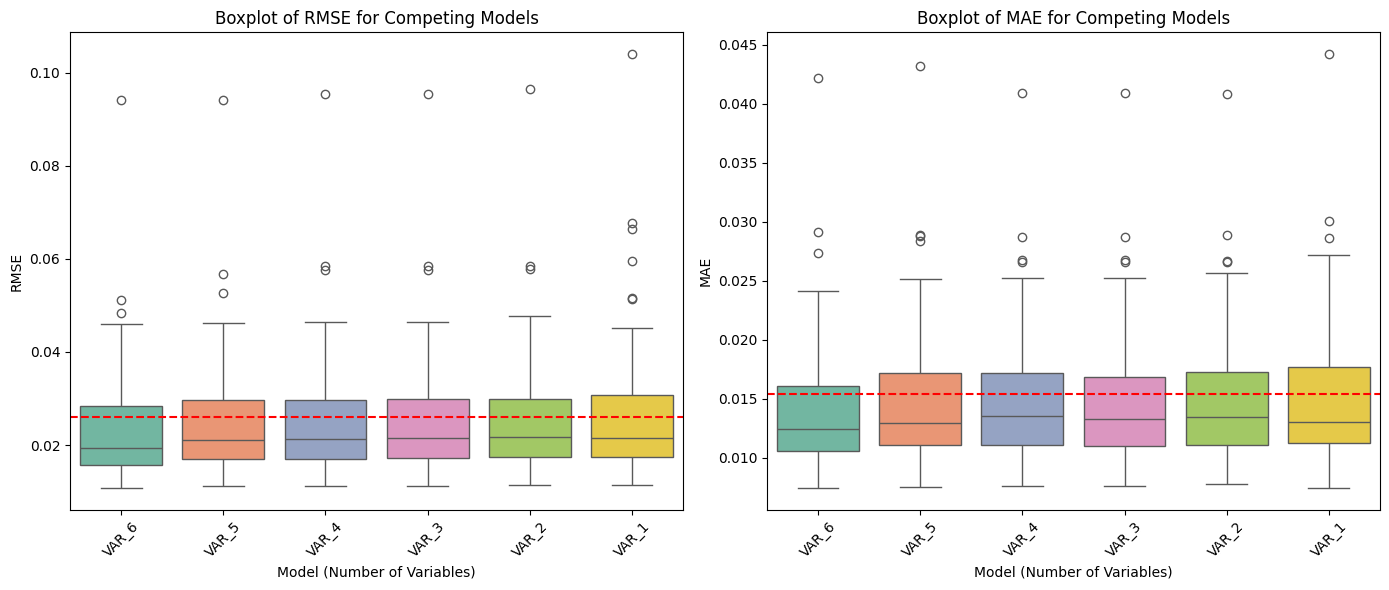

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all error metrics into a single DataFrame for visualization
all_errors_combined = []

for subset_columns, errors_df in all_errors:
    errors_df['Model'] = f"VAR_{len(subset_columns)}"  # Label for the number of variables
    all_errors_combined.append(errors_df)

all_errors_combined_df = pd.concat(all_errors_combined, ignore_index=True)

# Create boxplots for RMSE and MAE
plt.figure(figsize=(14, 6))

# RMSE Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Model', y='RMSE', data=all_errors_combined_df, palette="Set2")
plt.title("Boxplot of RMSE for Competing Models")
plt.xlabel("Model (Number of Variables)")
plt.ylabel("RMSE")
plt.axhline(y=all_errors_combined_df['RMSE'].mean(), color='r', linestyle='--')
plt.xticks(rotation=45)

# MAE Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='Model', y='MAE', data=all_errors_combined_df, palette="Set2")
plt.title("Boxplot of MAE for Competing Models")
plt.xlabel("Model (Number of Variables)")
plt.ylabel("MAE")
plt.xticks(rotation=45)
#add one line showing the average RMSE and MAE one for whole data
plt.axhline(y=all_errors_combined_df['MAE'].mean(), color='r', linestyle='--')

plt.tight_layout()
plt.show()


C:\Users\dabro\AppData\Local\Temp\ipykernel_1512\3401535852.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ratios_df, x="Model", y="RMSE_Ratio", palette="Set2")
C:\Users\dabro\AppData\Local\Temp\ipykernel_1512\3401535852.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ratios_df, x="Model", y="MAE_Ratio", palette="Set2")


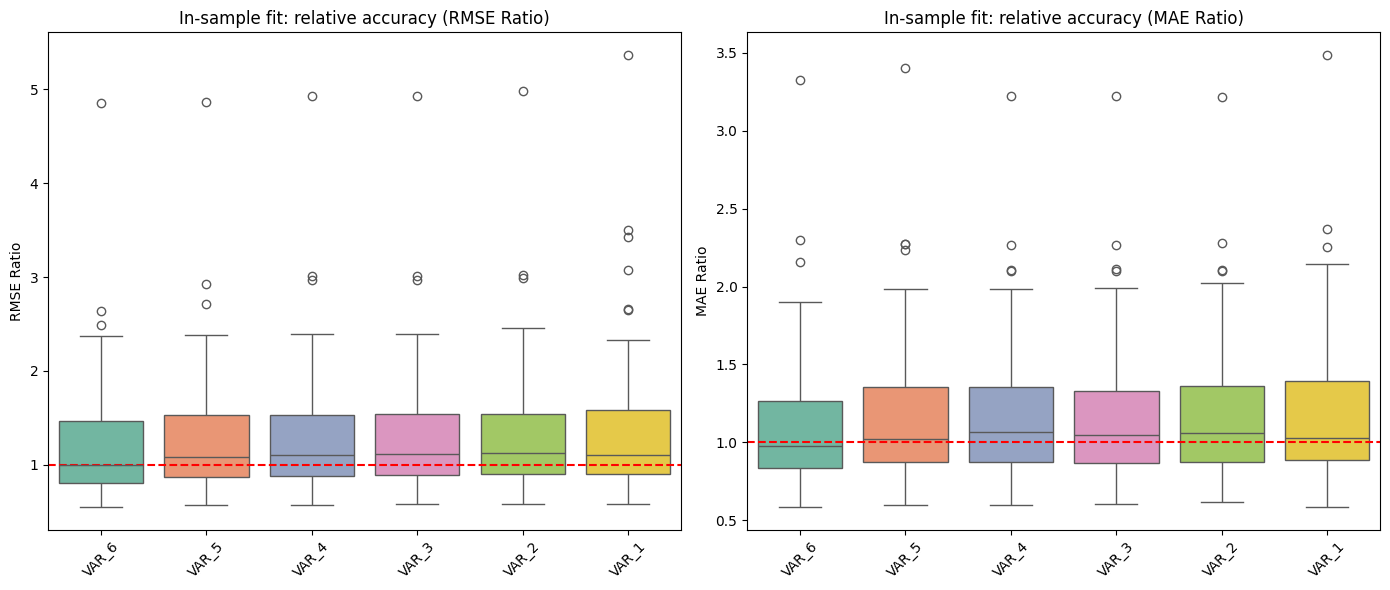

In [192]:
# Prepare RMSE and MAE ratios using all_errors
ratios = []  # This will store the RMSE and MAE ratios for each variable set

# Extract RMSE and MAE for the models with different numbers of variables
for i, (subset_columns, errors_df) in enumerate(all_errors):
    # Label models like VAR4, VAR5, etc.
    model_label = f"VAR_{len(subset_columns)}"
    errors_df["Model"] = model_label

    # Add the RMSE and MAE for this model to the ratios list
    ratios.append(errors_df[["RMSE", "MAE", "Model"]])

# Combine all error results
ratios_df = pd.concat(ratios, ignore_index=True)

# Calculate RMSE and MAE ratios
# Use VAR with fewer variables (e.g., VAR_4) as the baseline
baseline_model = "VAR_4"  # Adjust if a different baseline is required
baseline_rmse = ratios_df[ratios_df["Model"] == baseline_model]["RMSE"].values
baseline_mae = ratios_df[ratios_df["Model"] == baseline_model]["MAE"].values

ratios_df["RMSE_Ratio"] = ratios_df["RMSE"] / baseline_rmse[0]  # Adjust for single baseline
ratios_df["MAE_Ratio"] = ratios_df["MAE"] / baseline_mae[0]

# Plot RMSE and MAE Ratios

plt.figure(figsize=(14, 6))

# RMSE Ratios Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=ratios_df, x="Model", y="RMSE_Ratio", palette="Set2")
plt.axhline(y=1, color="red", linestyle="dashed")
plt.title("In-sample fit: relative accuracy (RMSE Ratio)")
plt.ylabel("RMSE Ratio")
plt.xlabel("")
plt.xticks(rotation=45)

# MAE Ratios Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=ratios_df, x="Model", y="MAE_Ratio", palette="Set2")
plt.axhline(y=1, color="red", linestyle="dashed")
plt.title("In-sample fit: relative accuracy (MAE Ratio)")
plt.ylabel("MAE Ratio")
plt.xlabel("")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\dabro\AppData\Local\Temp\ipykernel_1512\1559004243.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rmse_ratios_df, x="Model", y="Ratio", palette="Set2")
C:\Users\dabro\AppData\Local\Temp\ipykernel_1512\1559004243.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mae_ratios_df, x="Model", y="Ratio", palette="Set2")


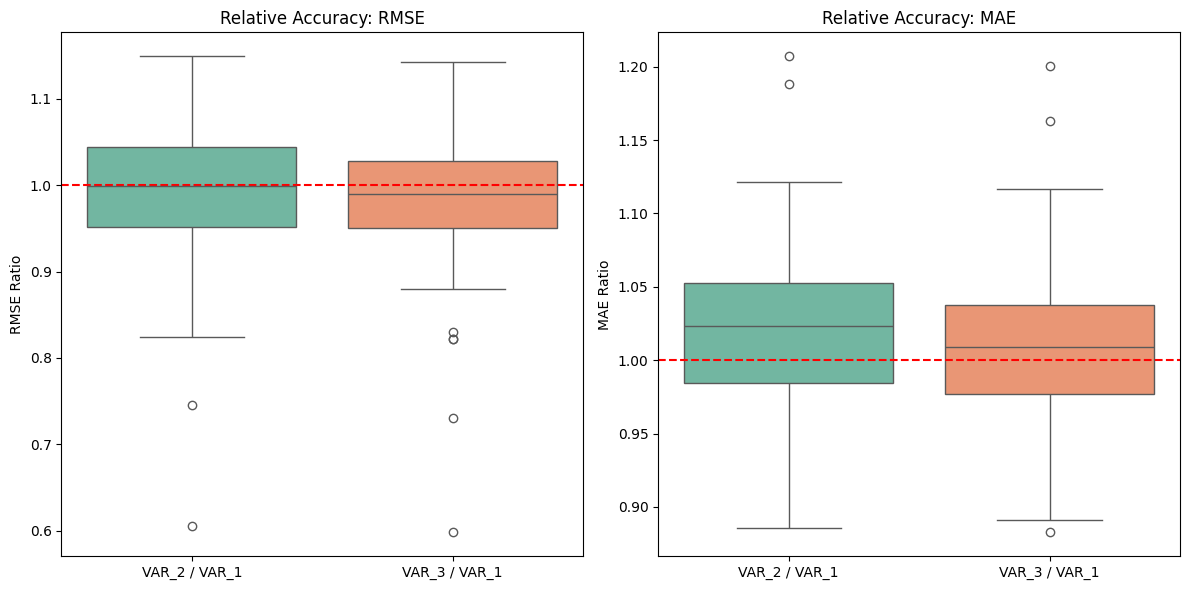

In [ ]:
# Extract RMSE and MAE values for VAR_4, VAR_5, and VAR_6
errors_var4 = [df for cols, df in all_errors if len(cols) == 1][0]  # VAR_4
errors_var5 = [df for cols, df in all_errors if len(cols) == 2][0]  # VAR_5
errors_var6 = [df for cols, df in all_errors if len(cols) == 3][0]  # VAR_6

# Calculate RMSE and MAE ratios
rmse_5_4 = errors_var5["RMSE"] / errors_var4["RMSE"]
rmse_6_4 = errors_var6["RMSE"] / errors_var4["RMSE"]

mae_5_4 = errors_var5["MAE"] / errors_var4["MAE"]
mae_6_4 = errors_var6["MAE"] / errors_var4["MAE"]

# Prepare data for plotting
rmse_ratios_df = pd.DataFrame({
    "Model": ["VAR_2 / VAR_1"] * len(rmse_5_4) + ["VAR_3 / VAR_1"] * len(rmse_6_4),
    "Ratio": list(rmse_5_4) + list(rmse_6_4)
})

mae_ratios_df = pd.DataFrame({
    "Model": ["VAR_2 / VAR_1"] * len(mae_5_4) + ["VAR_3 / VAR_1"] * len(mae_6_4),
    "Ratio": list(mae_5_4) + list(mae_6_4)
})

# Plot RMSE Ratios
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=rmse_ratios_df, x="Model", y="Ratio", palette="Set2")
plt.axhline(y=1, color="red", linestyle="dashed")
plt.title("Relative Accuracy: RMSE")
plt.ylabel("RMSE Ratio")
plt.xlabel("")

# Plot MAE Ratios
plt.subplot(1, 2, 2)
sns.boxplot(data=mae_ratios_df, x="Model", y="Ratio", palette="Set2")
plt.axhline(y=1, color="red", linestyle="dashed")
plt.title("Relative Accuracy: MAE")
plt.ylabel("MAE Ratio")
plt.xlabel("")

plt.tight_layout()
plt.show()



In [194]:
#prepare the table of rsme and mae for each model and state
#states are rows, models are columns 
# Extract RMSE and MAE values for VAR_4, VAR_5, and VAR_6
errors_var4 = [df for cols, df in all_errors if len(cols) == 4][0]  # VAR_4
errors_var5 = [df for cols, df in all_errors if len(cols) == 5][0]  # VAR_5
errors_var6 = [df for cols, df in all_errors if len(cols) == 6][0]  # VAR_6

#wihtout ratios

# Prepare RMSE and MAE ratios using all_errors
errors = []  # This will store the RMSE and MAE ratios for each variable set

# Extract RMSE and MAE for the models with different numbers of variables
for i, (subset_columns, errors_df) in enumerate(all_errors):
    # Label models like VAR4, VAR5, etc.
    model_label = f"VAR_{len(subset_columns)}"
    errors_df["Model"] = model_label

    # Add the RMSE and MAE for this model to the ratios list
    errors.append(errors_df)

# Combine all error results
errors_df = pd.concat(errors, ignore_index=True)
errors_df

,id,RMSE,MAE,Model
0,AL,0.017184,0.011447,VAR_6
1,AR,0.013321,0.009084,VAR_6
2,AZ,0.022847,0.015283,VAR_6
3,CA,0.019239,0.012037,VAR_6
4,CO,0.017149,0.012281,VAR_6
...,...,...,...,...
289,VT,0.104038,0.044231,VAR_1
290,WA,0.024050,0.013660,VAR_1
291,WI,0.019871,0.010468,VAR_1
292,WV,0.066475,0.030085,VAR_1


In [195]:
#make model names to be above the columns
errors_df = errors_df.pivot(index='id', columns='Model', values='RMSE')
errors_df

Model,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6
id,,,,,,
AL,0.020247,0.019891,0.019705,0.019390,0.019191,0.017184
AR,0.020383,0.016938,0.016752,0.016622,0.015985,0.013321
AZ,0.025360,0.025124,0.024758,0.024593,0.023288,0.022847
CA,0.020801,0.021320,0.021264,0.021264,0.019247,0.019239
CO,0.017500,0.018612,0.018055,0.017914,0.017912,0.017149
CT,0.019163,0.020036,0.019900,0.019827,0.019805,0.019805
DC,0.038240,0.041268,0.041188,0.041187,0.040808,0.039453
DE,0.051319,0.042282,0.042168,0.042160,0.041997,0.040116
FL,0.045130,0.033632,0.032939,0.032727,0.031739,0.029393


In [196]:
#the same for MAE
errors_df_mae = pd.concat(errors, ignore_index=True)
errors_df_mae = errors_df_mae.pivot(index='id', columns='Model', values='MAE')
errors_df_mae

Model,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6
id,,,,,,
AL,0.013002,0.012743,0.012492,0.012684,0.012439,0.011447
AR,0.011438,0.011007,0.010944,0.011156,0.010631,0.009084
AZ,0.016674,0.016426,0.016426,0.016449,0.015584,0.015283
CA,0.012798,0.012494,0.012318,0.012319,0.011956,0.012037
CO,0.011699,0.012571,0.012258,0.012293,0.012306,0.012281
CT,0.013669,0.013904,0.013677,0.013625,0.013663,0.013668
DC,0.023930,0.028890,0.028736,0.028750,0.028367,0.027332
DE,0.021309,0.022243,0.021749,0.021824,0.021725,0.019312
FL,0.021586,0.020617,0.020499,0.020619,0.020555,0.019334
